In [1]:
# 1. Imports and Setup
import sys, os
from sklearn.preprocessing import LabelEncoder
sys.path.append(os.path.abspath(".."))
from notebook_setup import *
from src.tuning import run_tuning_local, run_tuning_global

tracker = ExperimentTracker()

Checking dependencies in src/config.py...
  -> Chronos: True
  -> TimeGPT: True
  -> API Key: Found
Notebook setup complete.


Dataset: M5 Walmart Hobbies Daily (5 Series)
Total: 5 | Train: 5 | Test: 5
Train period: 2011-01-29 to 2016-03-27
Test period:  2016-03-28 to 2016-04-24
Seasonal period: 7
Dataset: M5 Walmart Hobbies Daily (5 Series)
Series: 5 | Train: 1885 | Test: 28
Train: 2011-01-29 to 2016-03-27
Test: 2016-03-28 to 2016-04-24


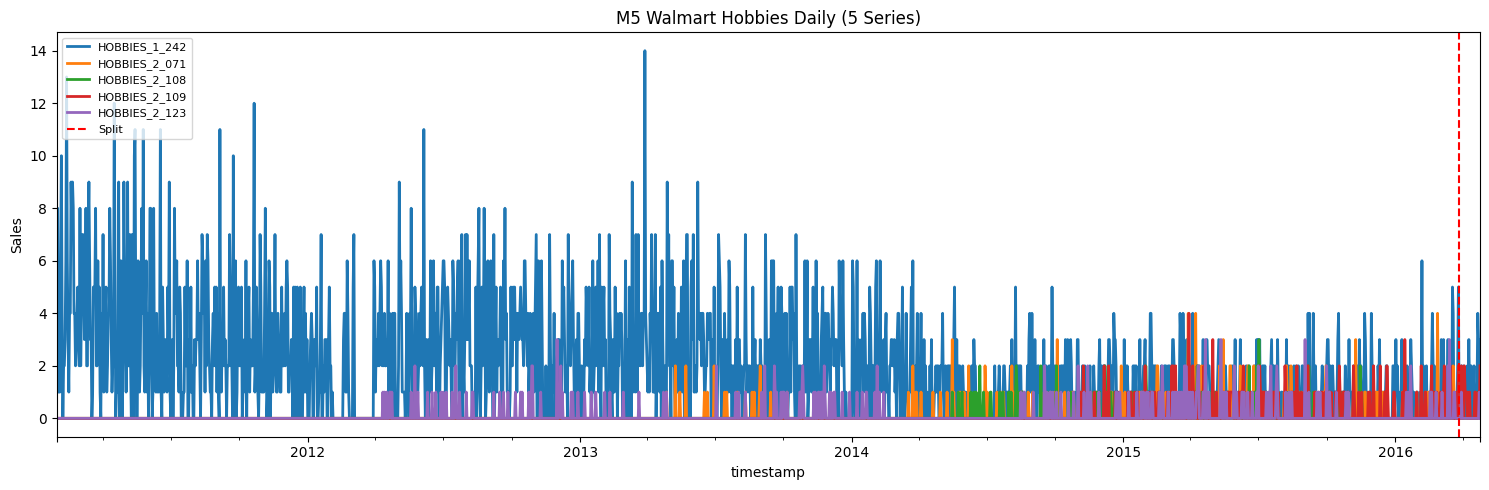

In [2]:
# 2. Data Configuration (Multi-Series)

DATASET_CONFIG = {
    "file_path": "../datasets/m5_walmart_hobbies_daily.csv",
    "time_column": "timestamp",
    "target_column": "sales_count",
    "id_column": "unique_id",
    "future_covariates": ["wday", "month"],
    "past_covariates": ["snap_CA", "snap_TX", "snap_WI"],
    "static_covariates": ["unique_id"],
    "frequency": "D",
    "test_periods": 28,
    "seasonal_period": 7,
    "name": "M5 Walmart Hobbies Daily (5 Series)",
    "value_unit": "Sales",
}

# Load Data
df = pd.read_csv(DATASET_CONFIG["file_path"])
df[DATASET_CONFIG["time_column"]] = pd.to_datetime(df[DATASET_CONFIG["time_column"]])
static_encoder = LabelEncoder()
df["unique_id_encoded"] = static_encoder.fit_transform(df[DATASET_CONFIG["id_column"]])

# Create Lists of Series
all_series, all_future_covs, all_past_covs = [], [], []
for uid in df[DATASET_CONFIG["id_column"]].unique():
    df_uid = df[df[DATASET_CONFIG["id_column"]] == uid].sort_values(
        DATASET_CONFIG["time_column"]
    )
    ts = TimeSeries.from_dataframe(
        df_uid,
        DATASET_CONFIG["time_column"],
        DATASET_CONFIG["target_column"],
        freq=DATASET_CONFIG["frequency"],
    ).astype(np.float32)

    static_covs = pd.DataFrame(
        {"unique_id": [uid], "unique_id_encoded": [df_uid["unique_id_encoded"].iloc[0]]}
    )
    ts = ts.with_static_covariates(static_covs)
    all_series.append(ts)

    if DATASET_CONFIG["future_covariates"]:
        all_future_covs.append(
            TimeSeries.from_dataframe(
                df_uid,
                DATASET_CONFIG["time_column"],
                DATASET_CONFIG["future_covariates"],
                freq=DATASET_CONFIG["frequency"],
            ).astype(np.float32)
        )
    if DATASET_CONFIG["past_covariates"]:
        all_past_covs.append(
            TimeSeries.from_dataframe(
                df_uid,
                DATASET_CONFIG["time_column"],
                DATASET_CONFIG["past_covariates"],
                freq=DATASET_CONFIG["frequency"],
            ).astype(np.float32)
        )

# === SMOKE TEST (Subset for faster tuning) ===
SMOKE_TEST = False
SMOKE_TEST_POINTS = 200

if SMOKE_TEST:
    print(f"SMOKE TEST ENABLED: Using last {SMOKE_TEST_POINTS} points per series.")
    all_series = [s[-SMOKE_TEST_POINTS:] for s in all_series]
    if all_future_covs:
        all_future_covs = [c[-SMOKE_TEST_POINTS:] for c in all_future_covs]
    if all_past_covs:
        all_past_covs = [c[-SMOKE_TEST_POINTS:] for c in all_past_covs]

# Split
test_periods = DATASET_CONFIG["test_periods"]
split_time = pd.Timestamp(all_series[0].end_time()) - pd.DateOffset(days=test_periods)

train_series = [s.split_after(split_time)[0] for s in all_series]
test_series = [s.split_after(split_time)[1] for s in all_series]

# Covariates Split
train_future_covs = (
    [c.split_after(split_time)[0] for c in all_future_covs] if all_future_covs else None
)
train_past_covs = (
    [c.split_after(split_time)[0] for c in all_past_covs] if all_past_covs else None
)

# Scaling
target_scaler = Scaler()
train_scaled = target_scaler.fit_transform(train_series)

future_scaler = Scaler()
train_future_covs_scaled = (
    future_scaler.fit_transform(train_future_covs) if train_future_covs else None
)
all_future_covs_scaled = (
    future_scaler.transform(all_future_covs) if all_future_covs else None
)

past_scaler = Scaler()
train_past_covs_scaled = (
    past_scaler.fit_transform(train_past_covs) if train_past_covs else None
)
all_past_covs_scaled = past_scaler.transform(all_past_covs) if all_past_covs else None

# Static Covariates for Embeddings
static_cov_transformer = StaticCovariatesTransformer()
train_scaled = static_cov_transformer.fit_transform(train_scaled)

# Print Dataset Summary
print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Total: {len(all_series)} | Train: {len(train_series)} | Test: {len(test_series)}")
print(f"Train period: {train_series[0].start_time().date()} to {train_series[0].end_time().date()}")
print(f"Test period:  {test_series[0].start_time().date()} to {test_series[0].end_time().date()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

# Visualize Train/Test Split for the all series
print(f"Dataset: {DATASET_CONFIG['name']}" + (" [SMOKE TEST]" if SMOKE_TEST else ""))
print(f"Series: {len(all_series)} | Train: {len(train_series[0])} | Test: {len(test_series[0])}")
print(f"Train: {train_series[0].start_time().date()} to {train_series[0].end_time().date()}")
print(f"Test: {test_series[0].start_time().date()} to {test_series[0].end_time().date()}")

fig, ax = plt.subplots(figsize=(15, 5))
for i, s in enumerate(all_series):
    s.plot(ax=ax, label=f'{s.static_covariates["unique_id"].values[0]}')
ax.axvline(x=split_time, color='red', linestyle='--', label='Split')
ax.set_title(f'{DATASET_CONFIG["name"]}' + (' [SMOKE TEST]' if SMOKE_TEST else ''))
ax.set_ylabel(DATASET_CONFIG.get('value_unit', 'Value'))
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In [3]:
# 3. Hyperparameter Tuning

SEASONAL_PERIOD = DATASET_CONFIG["seasonal_period"]
stat_grids = get_statistical_grids(SEASONAL_PERIOD)
dl_grids = get_dl_grids(SEASONAL_PERIOD)

In [4]:
# 4. Statistical Models (LOCAL)

# Holt-Winters
run_tuning_local(
    tracker,
    "Holt-Winters (LOCAL)",
    ExponentialSmoothing,
    stat_grids["Holt-Winters"],
    train_series,
    supports_covariates=False,
    seasonal_period=SEASONAL_PERIOD,
)

# AutoARIMA
run_tuning_local(
    tracker,
    "AutoARIMA (LOCAL)",
    AutoARIMA,
    stat_grids["AutoARIMA"],
    train_series,
    future_covs_list=all_future_covs,
    supports_covariates=True,
    seasonal_period=SEASONAL_PERIOD,
)

# Prophet
run_tuning_local(
    tracker,
    "Prophet (LOCAL)",
    Prophet,
    stat_grids["Prophet"],
    train_series,
    future_covs_list=all_future_covs,
    supports_covariates=True,
    seasonal_period=SEASONAL_PERIOD,
)

Holt-Winters (LOCAL): 100%|██████████| 15/15 [02:32<00:00, 10.18s/it, best=0.68, rmse=0.67]


Holt-Winters (LOCAL): RMSE=0.6749 | MAPE=0.00% | Time=152.7s (15 combinations)


AutoARIMA (LOCAL): 100%|██████████| 1/1 [31:38<00:00, 1898.75s/it, best=inf, rmse=0.68]


AutoARIMA (LOCAL): RMSE=0.6781 | MAPE=0.00% | Time=1898.8s (1 combinations)


Prophet (LOCAL): 100%|██████████| 6/6 [06:10<00:00, 61.70s/it, best=0.69, rmse=0.86]

Prophet (LOCAL): RMSE=0.6854 | MAPE=0.00% | Time=370.2s (6 combinations)


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5}

In [5]:
# 5. Deep Learning Models (GLOBAL)

# TiDE
run_tuning_global(
    tracker,
    "TiDE (GLOBAL)",
    TiDEModel,
    dl_grids["TiDE"],
    train_scaled,
    train_series,  # Původní (neskálovaná) data pro validaci
    target_scaler,
    future_covs=train_future_covs_scaled,
    past_covs=train_past_covs_scaled,
    seasonal_period=SEASONAL_PERIOD,
    n_iter=TUNING_CONFIG["N_ITER"],
)

# N-BEATS
run_tuning_global(
    tracker,
    "N-BEATS (GLOBAL)",
    NBEATSModel,
    dl_grids["N-BEATS"],
    train_scaled,
    train_series,
    target_scaler,
    future_covs=None,  # N-BEATS v této verzi nepoužívá kovariáty
    past_covs=None,
    seasonal_period=SEASONAL_PERIOD,
    n_iter=TUNING_CONFIG["N_ITER"],
)

# TFT
run_tuning_global(
    tracker,
    "TFT (GLOBAL)",
    TFTModel,
    dl_grids["TFT"],
    train_scaled,
    train_series,
    target_scaler,
    future_covs=train_future_covs_scaled,
    past_covs=train_past_covs_scaled,
    seasonal_period=SEASONAL_PERIOD,
    n_iter=TUNING_CONFIG["N_ITER"],
)

TiDE (GLOBAL): 100%|██████████| 4/4 [01:44<00:00, 26.06s/it, best=0.77, rmse=0.84]


TiDE (GLOBAL): RMSE=0.7730 | MAPE=0.00% | Time=104.2s (4 combinations)


N-BEATS (GLOBAL): 100%|██████████| 4/4 [04:27<00:00, 66.92s/it, best=0.82, rmse=0.95]


N-BEATS (GLOBAL): RMSE=0.8151 | MAPE=0.00% | Time=267.7s (4 combinations)


TFT (GLOBAL): 100%|██████████| 4/4 [09:40<00:00, 145.18s/it, best=2.11, rmse=2.03]

TFT (GLOBAL): RMSE=2.0336 | MAPE=0.00% | Time=580.7s (4 combinations)


{'input_chunk_length': 14,
 'output_chunk_length': 7,
 'n_epochs': 15,
 'batch_size': 32,
 'random_state': 42,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [6]:
# 6. Foundation Models (Chronos, TimeGPT)

run_foundation_models(tracker, train_series, test_series, DATASET_CONFIG["frequency"])

Val Inputs Length: [1857, 1857, 1857, 1857, 1857]
Val Targets Length: [28, 28, 28, 28, 28]
Chronos: RMSE=0.7546 | MAPE=0.00% | Time=9.0s (1 combinations)
TimeGPT: RMSE=0.6695 | MAPE=0.00% | Time=1.4s (1 combinations)


In [7]:
# 7. Results Comparison (Cross-Validation Metrics)

results_df = tracker.get_results_df()
print("=== Cross-Validation Results ===")
print(
    results_df[
        ["Model", "RMSE", "MAPE", "Tuning Time (s)", "Combinations"]
    ].to_string(index=False)
)

=== Cross-Validation Results ===
               Model     RMSE  MAPE  Tuning Time (s)  Combinations
             TimeGPT 0.669458   0.0         1.441350             1
Holt-Winters (LOCAL) 0.674862   0.0       152.669052            15
   AutoARIMA (LOCAL) 0.678142   0.0      1898.755457             1
     Prophet (LOCAL) 0.685384   0.0       370.201984             6
             Chronos 0.754626   0.0         9.037205             1
       TiDE (GLOBAL) 0.773002   0.0       104.243308             4
    N-BEATS (GLOBAL) 0.815060   0.0       267.673632             4
        TFT (GLOBAL) 2.033598   0.0       580.718644             4


In [8]:
# 8. Final Predictions with Best and Fastest Models

final_preds = get_final_predictions(
    tracker, train_series, test_series, target_scaler, train_scaled, DATASET_CONFIG["frequency"],
    future_covs=all_future_covs, 
    train_future_covs_scaled=train_future_covs_scaled, 
    train_past_covs_scaled=train_past_covs_scaled,
    all_future_covs_scaled=all_future_covs_scaled,
    all_past_covs_scaled=all_past_covs_scaled
)

Retraining Best: TimeGPT


In [9]:
# 9. Final Predictions with Best and Fastest Models

for i in range(len(train_series)):
    fig = plot_forecast_comparison(
        train_series,
        test_series,
        final_preds,
        DATASET_CONFIG["name"],
        DATASET_CONFIG.get("target_column"),
        DATASET_CONFIG.get("value_unit"),
        series_idx=i,
    )
    fig.show()

In [10]:
# 10. Model Comparison Chart (NO MAPE)

# Zde voláme funkci s plot_mape=False, aby se skryl pravý horní graf
fig_comp = plot_model_comparison(
    tracker.get_results_df(),
    DATASET_CONFIG["name"],
    value_unit=DATASET_CONFIG.get("value_unit"),
    plot_mape=False,  # <--- VYPNUTÍ MAPE
)
fig_comp.show()

In [11]:
# 11. Export Static PNG Images


for i in range(len(train_series)):
    fig = plot_forecast_comparison(
        train_series, test_series, final_preds, DATASET_CONFIG["name"], series_idx=i
    )
    sid = train_series[i].static_covariates["unique_id"].values[0]
    export_plots(fig, None, DATASET_CONFIG["name"], suffix=sid)

export_plots(None, fig_comp, DATASET_CONFIG["name"])